<a href="https://colab.research.google.com/github/novoda/spikes/blob/master/sentiment-analysis/Sentiment_Analysis_for_the_general_Slack_channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis for Slack channels**
What we will be doing:
  1. Retrieve the `channel_id` for `#general`
  2. Retrieve the channel history from 31/05/2020
  3. Filter out non-user messages
  4. Run sentiment analysis on the list of retrieved messages. Values `<0` are for negative sentiment, values `>0` for positive sentiment.
  5. Some data processing to group by date and split the data in two columns, one for `number of possitive messages` and one for `number of negative messages`
  6. Plot the data!

---------------------

First of all, let's install `slack_sdk` package, which is what we'll be using to make calls to the Slack API

In [ ]:
!pip install slack_sdk

Now, let's import the dependencies for our project

In [ ]:
import logging
import os
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt



Instantiate a logger for the possible error messages


In [ ]:
logger = logging.getLogger(__name__)

-------------------------------
**Data Retrieval**


We will instantiate `client` for making calls to the Slack API
`token` is the token for your Slack App or Bot.

When creating your App or Bot there is something to consider. `OAuth` `channels:history` and `channels:read` scopes needs to be added to either `Bot Token Scopes` or `User Token` scopes. This is under your app management settings on `OAuth & Permissions`.

In [ ]:
client = WebClient(token="YOUR-TOKEN-HERE")

Now we need to retrieve the `channel_id` which identifies the channel on which we are willing to perform the sentiment analysis.
1. Request `conversations_list`
2. Loop throught the list of channels until we find a match by `name`
3. Get the `id` for the channel that matched the `name`

In [ ]:
channel_id = None
target = 'general'
try:
    result = client.conversations_list()
    for response in result:
        for channel in result["channels"]:
            if channel["name"] == target:
                channel_id = channel["id"]
                break
except SlackApiError as e:
    logger.error("Error: {}".format(e))

Once we have the `channel_id` for the channel we are going to be working on, it's time to retrieve the channel history.

We retrieve messages from 31 May 2020, but there is a limitation on the `conversations_history` method, there is a limit of `1000` messages for call, so we need to perform multiple calls for different 

There is a constraint on the 

In [ ]:
conversation_history = []

try:
    # Call the conversations.history method using the WebClient
    # conversations.history returns the first 100 messages by default, with a maximum of 1000
    pending_messages = True
    start_date = 1590883200 # 31 May 2020
    conversation_history = []
    while pending_messages:
        result = client.conversations_history(channel=channel_id, inclusive=False, oldest=start_date, count=1000)["messages"]
        conversation_history = conversation_history + result
        if len(result) == 0:
            pending_messages = False
        else:
            start_date = result[0].get('ts')
            pending_messages = True
except SlackApiError as e:
    logger.error("Error: {}".format(e))

Next thing we do is to filter out everything which is not a message (like notifications) and messages that are not from users (there is no `client_message_id` associated to it).

In [ ]:
filtered_history = list(
    filter(
        lambda x: x.get('type') == 'message' and x.get('client_msg_id') is not None,
        conversation_history
    )
)


And a matrix is created with `date` and `text` of the message as columns

In [ ]:
conversation_history_messages_by_date = list(
    map(
        lambda x: [datetime.fromtimestamp(float(x.get('ts'))).strftime("%Y%m%d"), x.get('text')],
        filtered_history
    )
)

conversation_history_messages_by_date

---------------------------------
**Sentiment Analysis**

The first thing we are going do to towards this approach is to download the `VADER` lexicon. An ordered series of words mapped to the sentiment they transmit. `VADER` stands for Valence Aware Dictionary and sEntiment Reasoner.

This is going to be used by [Neural Language Tool Kit](https://www.nltk.org/), `nltk`, in order to be able to analyse sentiments of messages. 

In [ ]:
nltk.download('vader_lexicon')

Once the dictionary is downloaded, we instantiate our `SentimentIntensityAnalyzer`

In [ ]:
analyzer = SentimentIntensityAnalyzer()

And we analyze sentiments. We map the `conversation_history_messages_by_date` soo the `message` column is transformed to `sentiment`.

A value under 0 is considered a negative sentiment
A value over 0 is considered a positive sentiment

In [ ]:
conversation_history_sentiments_by_date = list(
    map(
        lambda x: [x[0], analyzer.polarity_scores(x[1]).get('compound')],
        conversation_history_messages_by_date
    ),
)

Finally, for data representation, we are grouping the data by `date` and creating two separate columns. 
1. `negative` containing the number of negative messages on a date
2. `positive` containing the number of positive messages on a date

In [ ]:
net_sentiment_by_date = pd.DataFrame(conversation_history_sentiments_by_date, columns=["date", "sentiment"])
net_sentiment_by_date = net_sentiment_by_date.groupby('date')['sentiment'].agg(
    positive=lambda x: x.gt(0).sum(),
    negative=lambda x: x.lt(0).sum()
)

net_sentiment_by_date

And we plot our data. We are done!

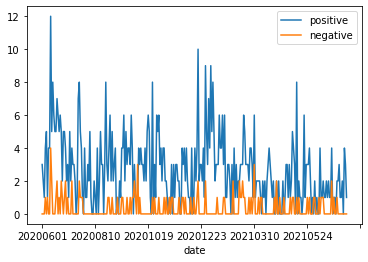

In [ ]:
net_sentiment_by_date[['positive', 'negative']].plot()
plt.show()